This notebook will use OPTICS to cluster the image of the first page of the documents.

First, the images will directly be read as 32x32 greyscale images and OPTICS will be used on those.

Second, Eigendocs will be used to reduce the dimensionality of the images and OPTICS will be used on those.

### directly read reduced quality images

In [195]:
import cv2
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from sklearn.cluster import OPTICS
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [196]:
# data
documents_small_raw = [cv2.resize(plt.imread(fp.path), (32, 32)) for fp in os.scandir("/Users/klara/Documents/uni/bachelorarbeit/images") if fp.path.endswith(".png")]

In [197]:
def rgb2gray(img):
    return 0.299*img[:,:,0] + 0.587*img[:,:,1] + 0.114*img[:,:,2]

In [198]:
def get_maximum_height_width(documents):
    max_w = 0
    max_h = 0
    for doc in documents:
        max_w = np.maximum(max_w, doc.shape[0])
        max_h = np.maximum(max_h, doc.shape[1])
    return max_w, max_h

In [199]:
def proprocess_docs(raw_documents, max_w, max_h):
    '''
    return same sized, greyscale documents as an array
    '''
    documents = []
    for doc in raw_documents:
        # same size for all documents
        C = np.ones((max_w,max_h))
        # convert to grayscale
        C[:doc.shape[0],:doc.shape[1]] = rgb2gray(doc)
        # 2d to 1d array
        documents.append(C.ravel())
    # list to array
    return np.asarray(documents)

In [200]:
max_w_small, max_h_small = get_maximum_height_width(documents_small_raw)

In [201]:
documents_small = proprocess_docs(documents_small_raw, max_w=max_w_small, max_h=max_h_small)

### use Eigendocs to reduce dimensionality

In [202]:
documents_raw = [plt.imread(fp.path) for fp in os.scandir("/Users/klara/Documents/uni/bachelorarbeit/images") if fp.path.endswith(".png")]

In [203]:
max_w, max_h = get_maximum_height_width(documents_raw)
print(max_w, max_h)

880 1026


In [204]:
eigendocs = proprocess_docs(documents_raw, max_w=max_w, max_h=max_h)

In [205]:
def display_first_docs(documents, n, max_w, max_h):
    '''
    display first n documents
    '''
    fcols = 10
    rows = int(np.ceil(len(documents[:n])/fcols))
    plt.figure(figsize=(20,rows*2))
    for i,doc in enumerate(documents[:n]):
        plt.subplot(rows, fcols, 1+i)
        plt.imshow(doc.reshape(max_w,max_h), cmap=plt.cm.bone)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

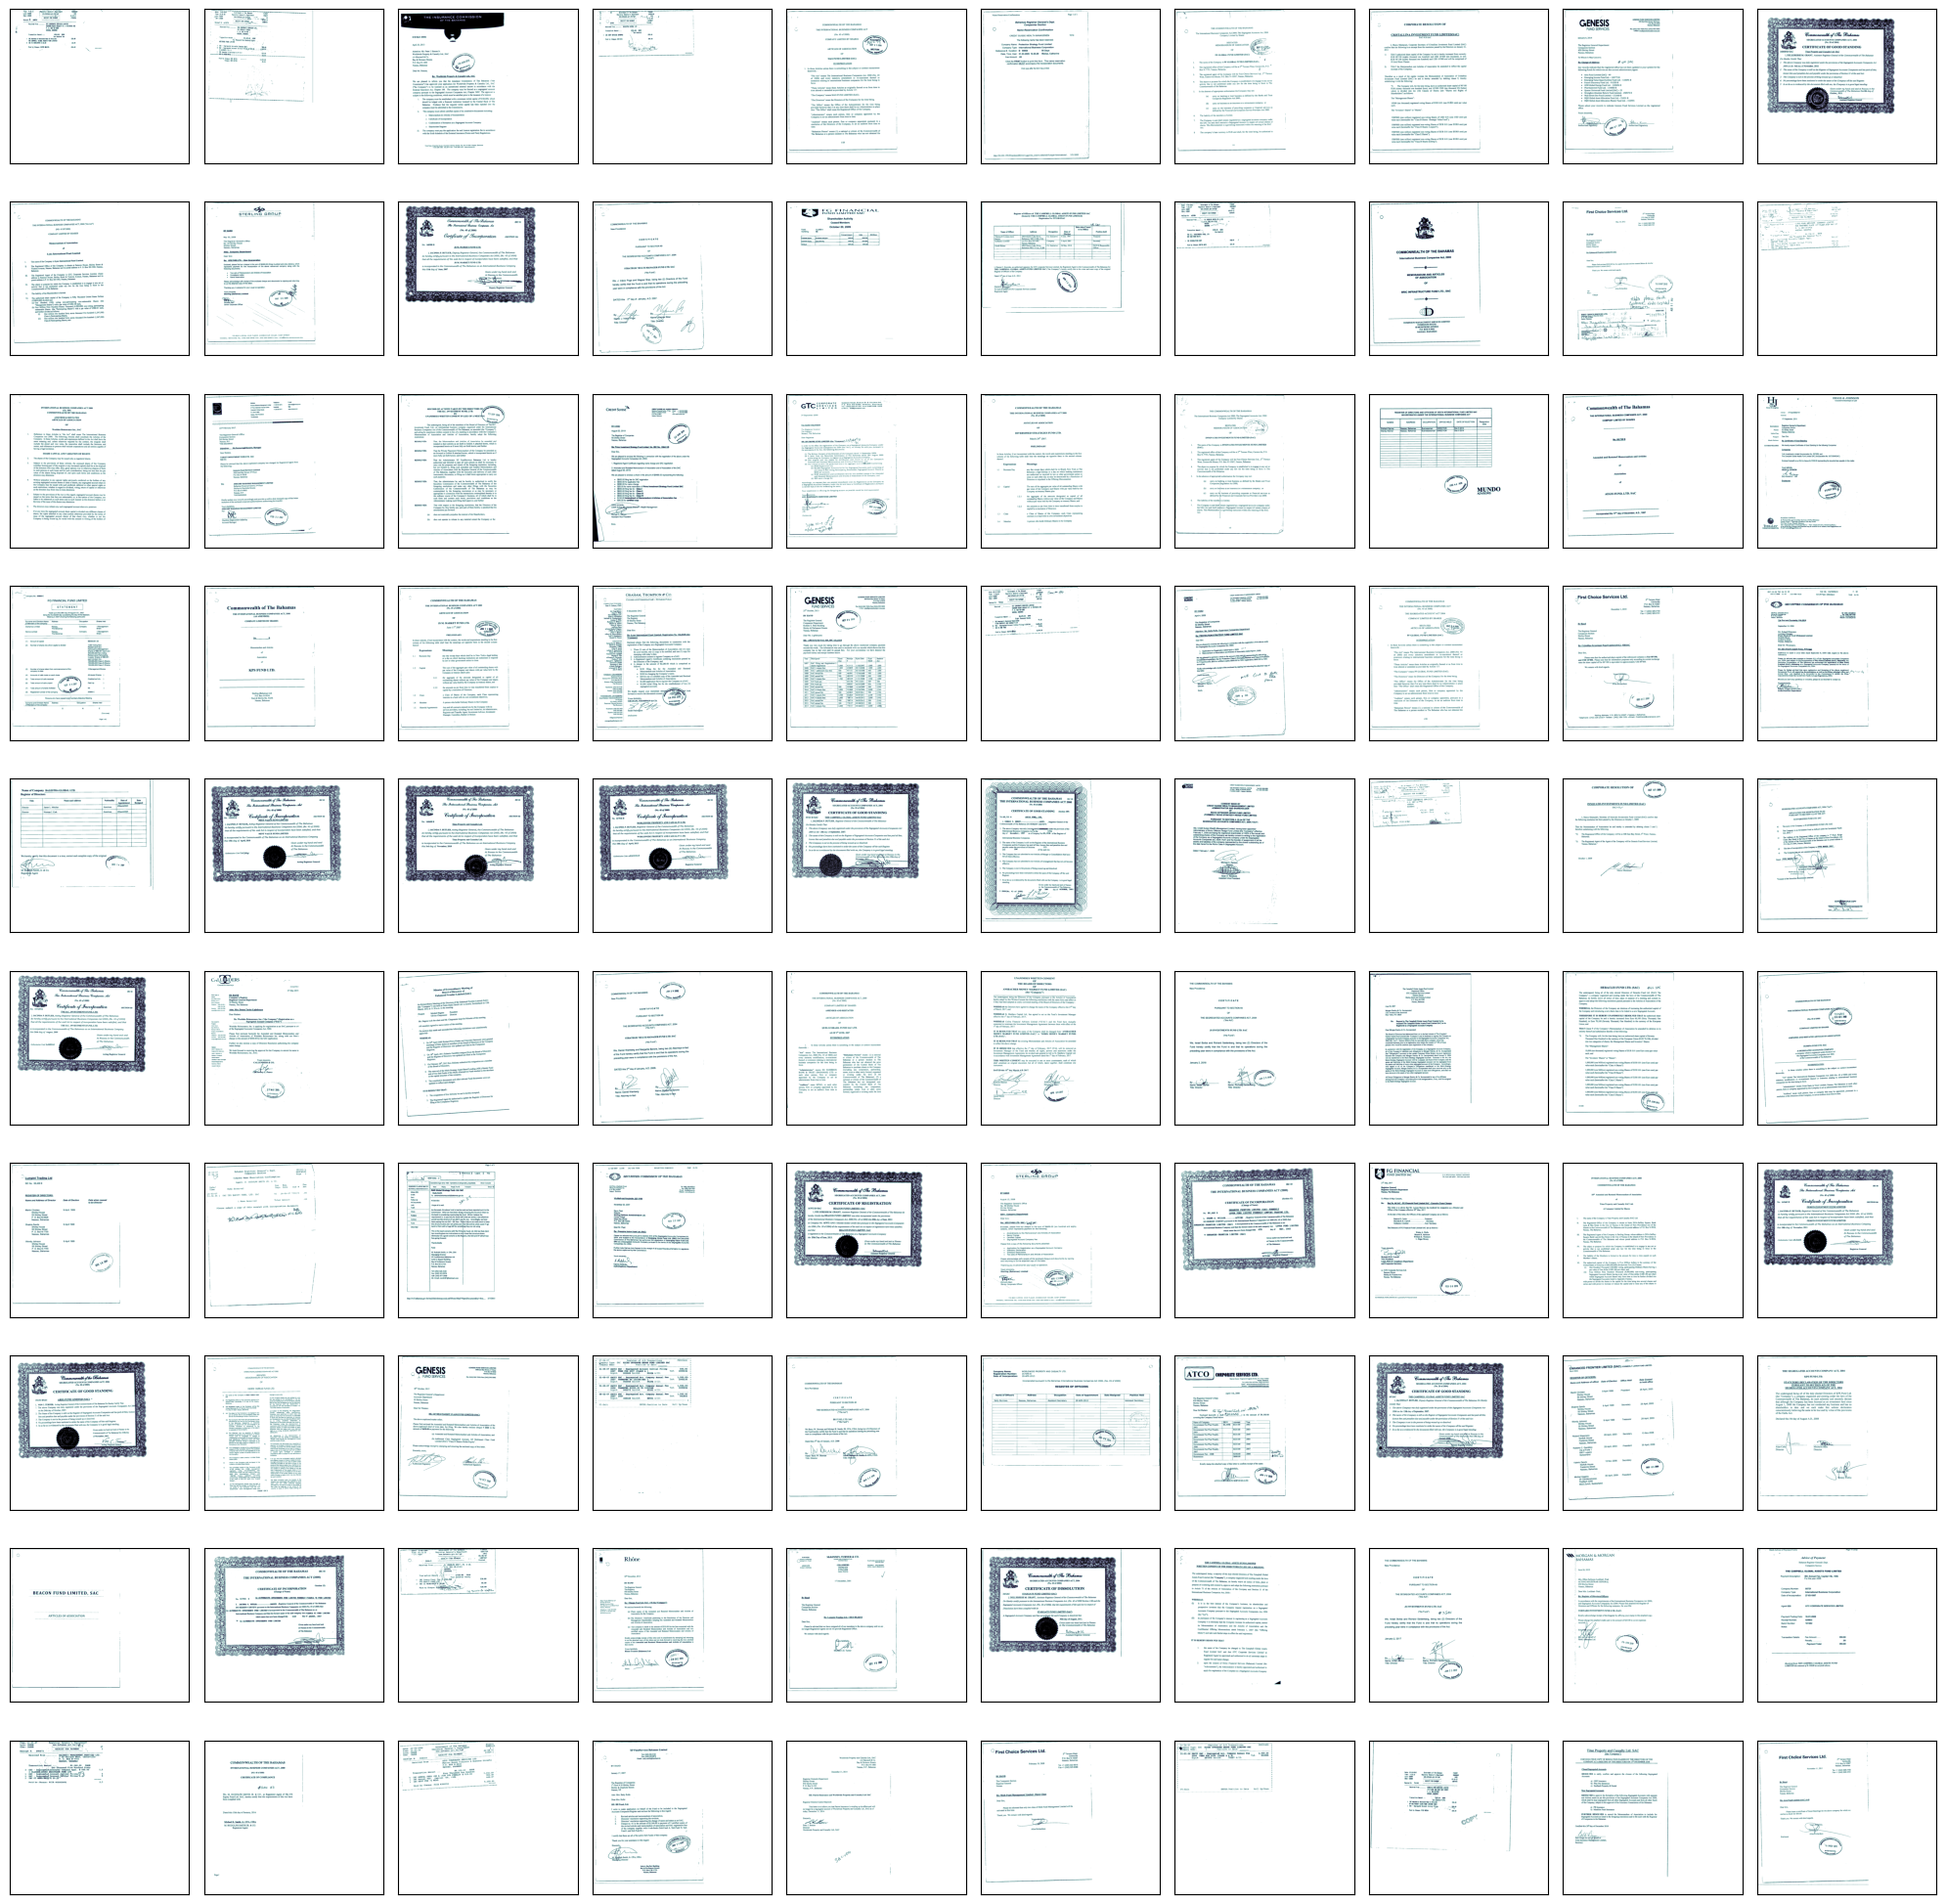

In [206]:
display_first_docs(eigendocs, 100, max_w=max_w, max_h=max_h)

In [207]:
X_train, X_test = train_test_split(eigendocs, random_state=0)

for some reason clustering on 4 dim data work better than on 196 dim data

In [208]:
import math


sqr_n_c=2 # clustering on 32 (min returns 14x14) works not as well as two
pre_n_comp = min(sqr_n_c, int(math.sqrt(len(X_train))), int(math.sqrt(len(X_train[0]))))
# svd solver is part of eigendocs algorithm: XX^T to X^TX and use algorithm for eigenvectors
pca = PCA(n_components=pre_n_comp**2, whiten=True, svd_solver="randomized")

In [209]:
pca.fit(X_train)

PCA(n_components=4, svd_solver='randomized', whiten=True)

In [210]:
# 10 test documents
idx=np.random.choice(len(X_test), replace=False, size=10)
idx

array([43, 29, 45, 16, 30, 12, 23, 28, 17, 31])

In [211]:
transposed_img = pca.transform(X_test[idx])
reconstructed_img = pca.inverse_transform(transposed_img)

width=max_w
height=max_h

In [212]:
def display_PCA_res(transposed_img, reconstructed_img, X_test, save=False, sqr_n_c=sqr_n_c):
    # test images
    # display original, reconstructed, difference (error of reconstruction), transformation, and transformation (?) plot
    plt.figure(figsize=(20,10))
    plt.tight_layout()
    for n,i in enumerate(idx):
        plt.subplot(5,10,1+n)
        plt.imshow(X_test[i].reshape(width,height), cmap=plt.cm.bone)
        plt.xticks([])
        plt.yticks([])
        plt.subplot(5,10,11+n)
        plt.imshow(reconstructed_img[n].reshape(width,height), cmap=plt.cm.bone)
        plt.xticks([])
        plt.yticks([])
        plt.subplot(5,10,21+n)
        plt.imshow((X_test[i]-reconstructed_img[n]).reshape(width,height), cmap=plt.cm.bone)
        plt.xticks([])
        plt.yticks([])
        plt.subplot(5,10,31+n)
        plt.imshow(transposed_img[n].reshape(sqr_n_c,sqr_n_c), cmap=plt.cm.bone)
        plt.xticks([])
        plt.yticks([])
        plt.subplot(5,10,41+n)
        plt.plot(transposed_img[n],'m')  # m is magenta
        plt.xticks([])
        plt.yticks([])
    if save:
        plt.savefig("/Users/klara/Developer/Uni/topic-analysis-text-data/results/eigendocs.pdf", format="pdf")
    plt.show()

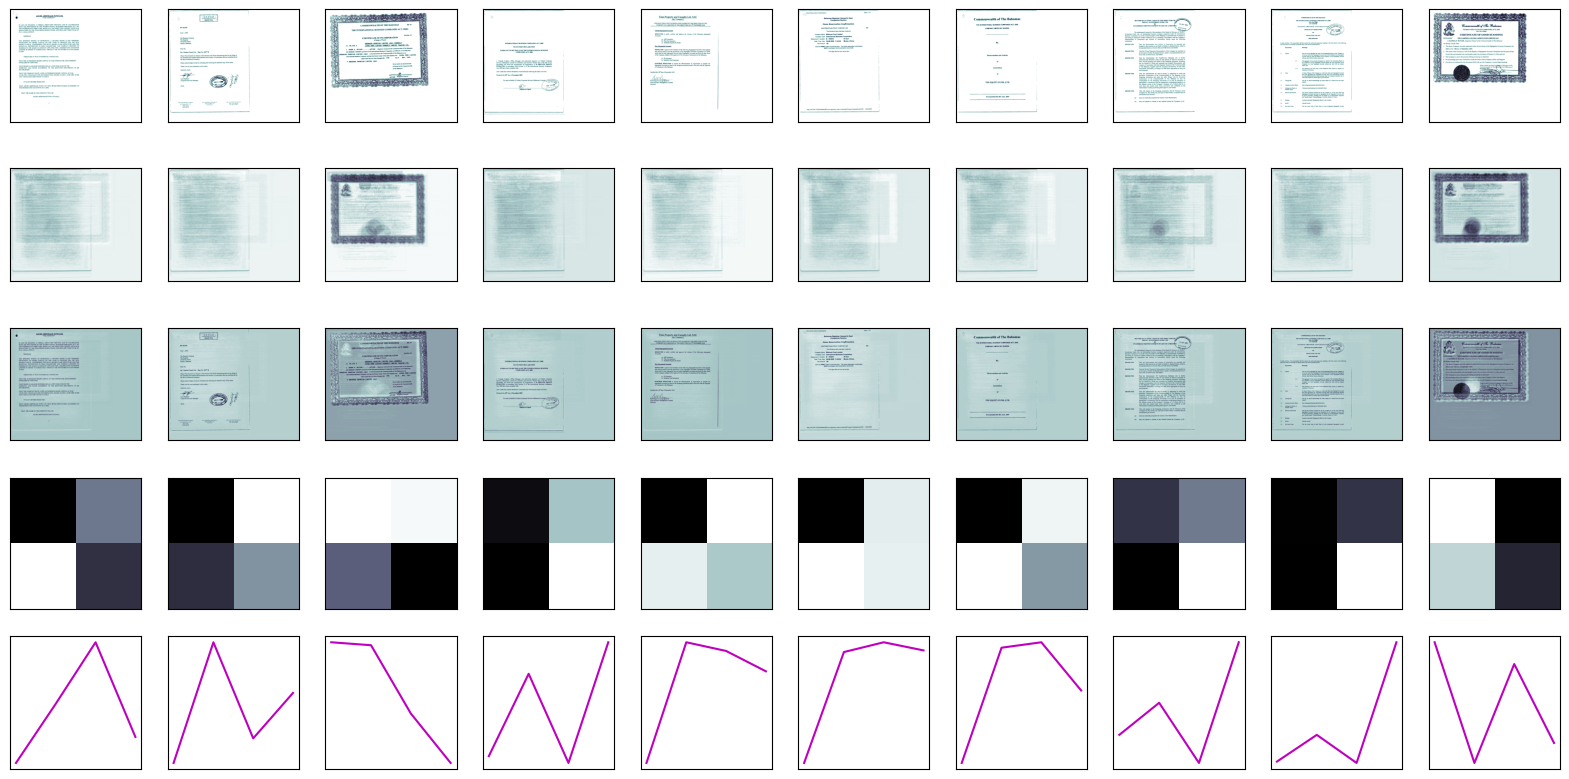

In [213]:
display_PCA_res(transposed_img, reconstructed_img, X_test, save=True, sqr_n_c=pre_n_comp)

OPTICS

eigendocs

In [214]:
# training images
trans_train = pca.transform(X_train)    # lower dimensional representation of training data

In [223]:
clt = OPTICS(cluster_method='dbscan', min_samples=2, max_eps=10, eps=0.5)
labels = clt.fit_predict(trans_train)    # on lower dimensional representation of training data

In [224]:
def dispaly_OPTICS_clustering(trans_train, labels):
    fig, ax = plt.subplots()
    scatter = ax.scatter(*trans_train[:,[0,1]].T, c=labels)   # display docs first (PCA) two components and their cluster
    legend = ax.legend(*scatter.legend_elements(), title="Classes")
    ax.add_artist(legend)
    plt.show()

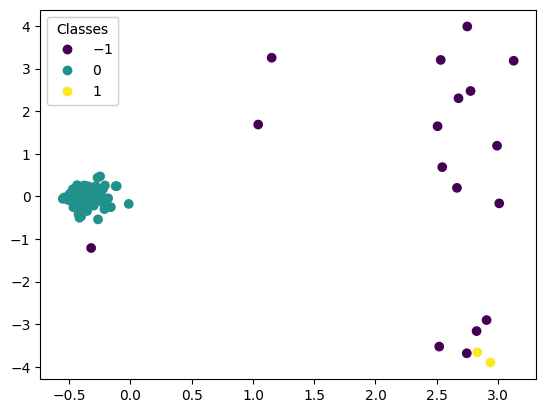

In [225]:
dispaly_OPTICS_clustering(trans_train, labels)

In [226]:
def display_cluster_content(X_train, labels, max_w, max_h):
    print(labels, max_w, max_h)
    classes = np.unique(labels)[1:]  # index zero is noise
    n_cols = np.histogram(labels)[0][1:].max()   # number of columns is the maximum number of documents in a cluster
    n_rows = len(classes)   # number of rows is the number of clusters
    X = X_train
    plt.figure(figsize=(2*n_cols,2*n_rows))
    for i,c in enumerate(classes):  # cluster number c
        for j,t in enumerate(X[labels==c]):  # document number t
            plt.subplot(n_rows,n_cols,i*n_cols+j+1)
            plt.imshow(t.reshape(max_w,max_h))  # 1d to 2d array
            plt.xticks([])
            plt.yticks([])
    print(X.shape)
    plt.show()

[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0 -1  0  0  0  0  0 -1  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  1  0
  0  0  0 -1  0 -1 -1  0  0 -1  0  0  0 -1  0  0  0  0  0  0  0  0  0  0
 -1  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0 -1  0  0 -1  0  0 -1  0  0  0  0  0  0  0  1  0  0  0 -1  0  0  0  0
  0] 880 1026
(145, 902880)


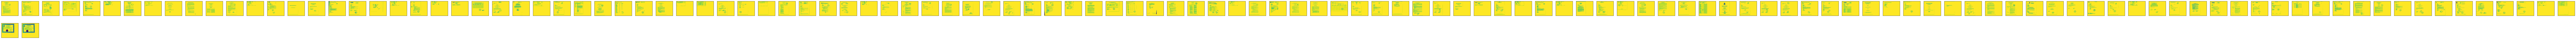

In [227]:
display_cluster_content(X_train, labels, max_w, max_h)

directly read images in reduced quality

In [220]:
clt_small = OPTICS(min_samples=2, max_eps=10, cluster_method='dbscan')
labels_small = clt.fit_predict(documents_small)    # on data (more than used above)

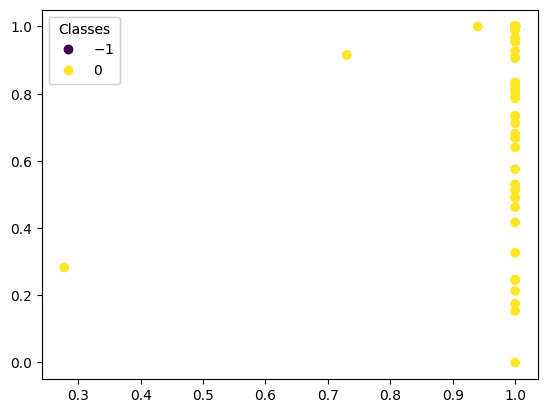

In [221]:
dispaly_OPTICS_clustering(documents_small, labels_small)

eigenfaces works better!

[ 0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0] 32 32
(194, 1024)


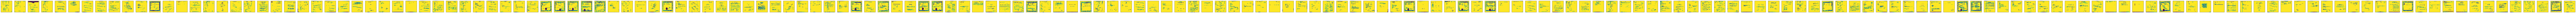

In [222]:
display_cluster_content(documents_small, labels_small, 32, 32)

32x32 images result are very bad,
Eigenfaces perform better, but only on 4 dimensions (as opposed to 196 dimensions).